In [18]:
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np
import matplotlib.pyplot as plt

# Load data
print('Loading data...')
crime_df = pd.read_csv('data/Crimes_-_2001_to_2021.csv')
print('Loaded the data!')

# Cleaning dataframe
crime_df.drop(columns=['Case Number','Block','IUCR','Primary Type', # IUCR of Primary Type ?
                        'Description','Location Description','Arrest', # Location Description voor LSTM ?
                        'Domestic','Beat','District','Ward','Community Area', # Community Are voor visualisatie
                        'FBI Code','Updated On','Location'], inplace=True)
crime_df = crime_df.rename(columns={'X Coordinate':'x', 'Y Coordinate':'y'})
crime_df.dropna(inplace=True)

print('Converting to datetime column')
year_crime_df = crime_df.loc[crime_df['Year'] == 2021]
year_crime_df['Date'] = pd.to_datetime(year_crime_df['Date'])
print('Done.')

Loading data...
Loaded the data!
Converting to datetime column
Done.


C:\Users\lcdew\AppData\Local\Temp\ipykernel_6252\1078068602.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_crime_df['Date'] = pd.to_datetime(year_crime_df['Date'])


In [40]:
def plot_crime_data(month_crime_df, frame_i):
    print(f'Creating plot for month {frame_i}')

    path = 'data/shapefile/geo_export.shp'
    chicago = gpd.read_file(path)
    chicago = chicago.dissolve()

    crs = "EPSG:4326"
    gdf = gpd.GeoDataFrame(month_crime_df, geometry=gpd.points_from_xy(month_crime_df.Longitude, month_crime_df.Latitude), crs=crs)

    xmin, ymin, xmax, ymax = chicago.total_bounds
    n_x_cells = 50
    x_cell_size = (xmax - xmin) / n_x_cells
    n_y_cells = round(((ymax - ymin)/(xmax - xmin))*n_x_cells)
    y_cell_size = (ymax - ymin) / n_y_cells
    grid_cells = []
    for x0 in np.arange(xmin, xmax+x_cell_size, x_cell_size):
        for y0 in np.arange(ymin, ymax+y_cell_size, y_cell_size):
            x1 = x0-x_cell_size
            y1 = y0+y_cell_size
            box = shapely.geometry.box(x0, y0, x1, y1)
            if chicago.intersection(box).any():
                grid_cells.append(box)
    cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

    merged = gpd.sjoin(gdf, cell, how='left', predicate='within')
    merged['n_crimes'] = 0
    dissolve = merged.dissolve(by="index_right", aggfunc="count")
    cell['n_crimes'] = 0
    cell.loc[dissolve.index, 'n_crimes'] = dissolve.n_crimes.values

    vmax = cell.n_crimes.mean() + 2*cell.n_crimes.std()
    ax = cell.plot(column='n_crimes', figsize=(12, 8), vmax=vmax, cmap='jet', edgecolor=None)
    chicago.plot(ax=ax, color='none', edgecolor='black')
    ax.axis('off')
    plt.title(f'Crimes in Chicago in {frame_i}/2021')
    plt.savefig(f'data/visualisation/frame_{frame_i}.png', dpi=300, bbox_inches='tight');

Creating plot for month 1
Creating plot for month 2
Creating plot for month 3
Creating plot for month 4
Creating plot for month 5
Creating plot for month 6
Creating plot for month 7
Creating plot for month 8
Creating plot for month 9
Creating plot for month 10


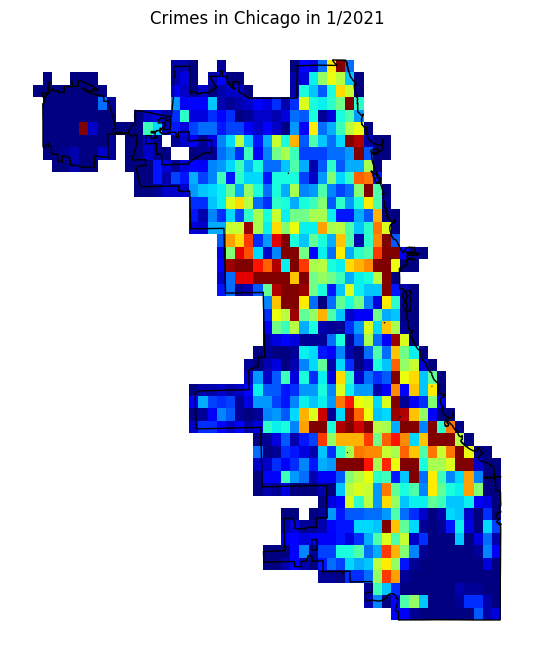

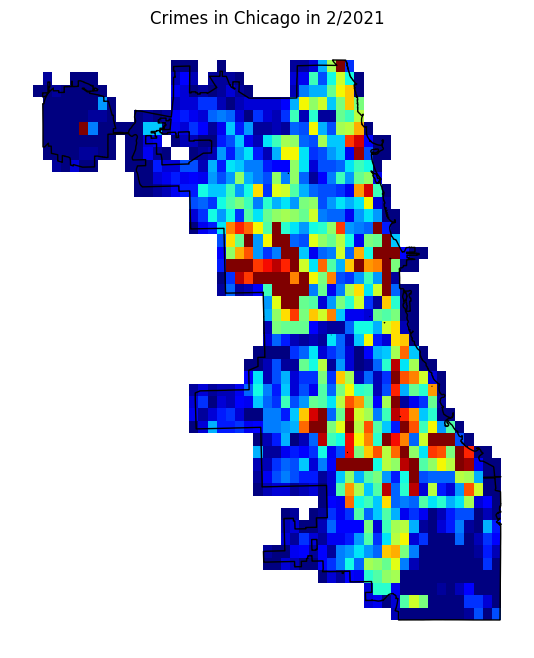

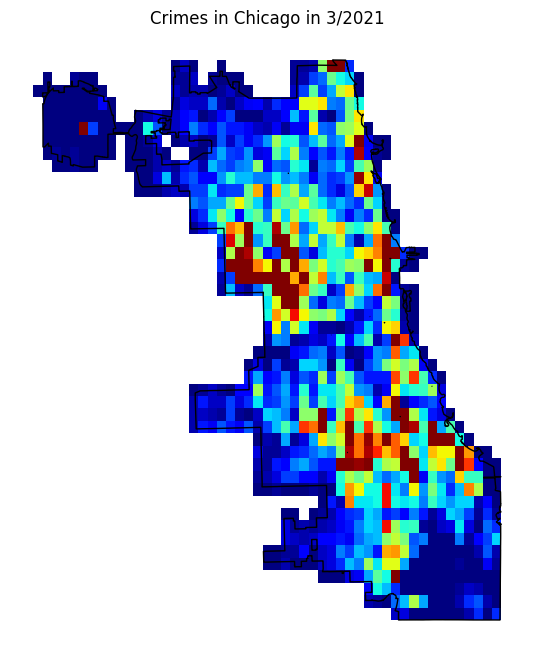

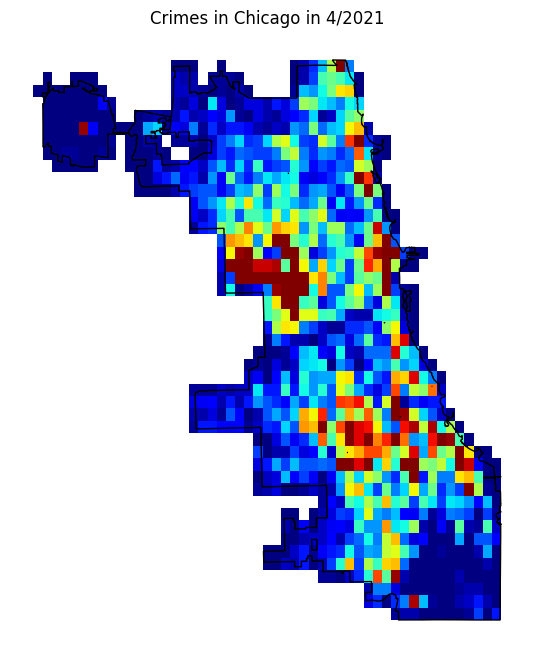

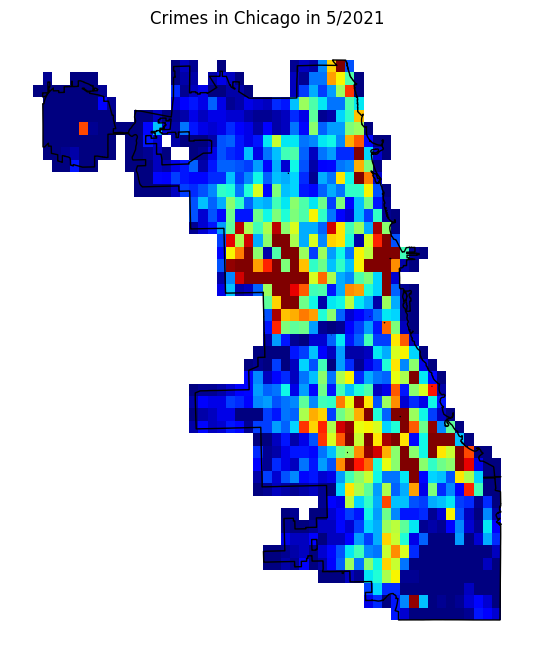

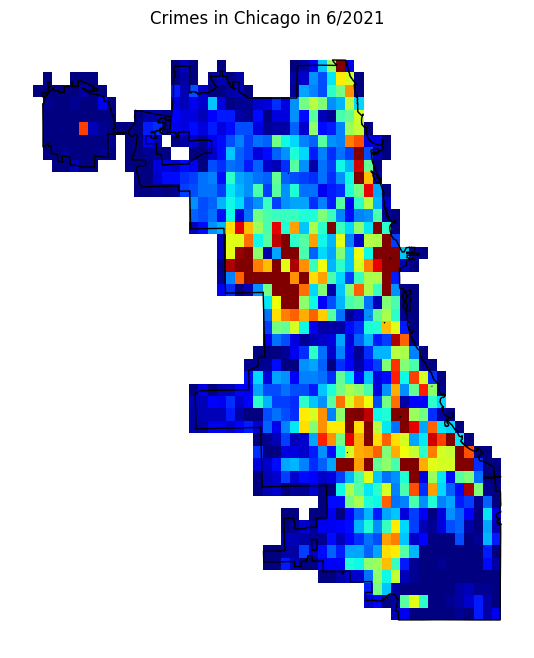

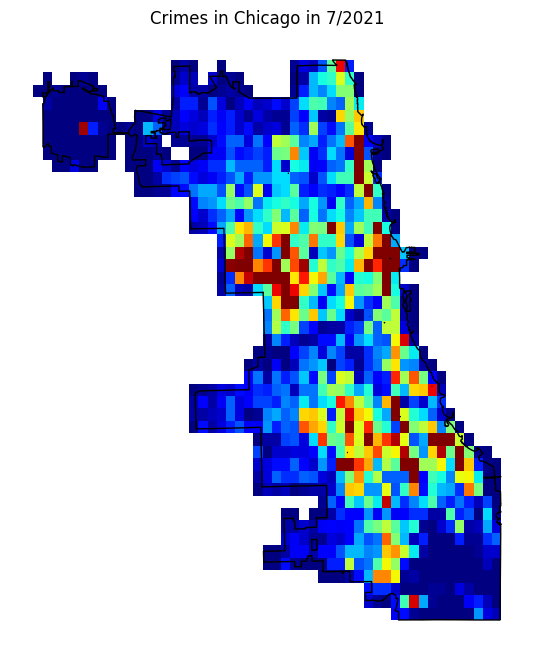

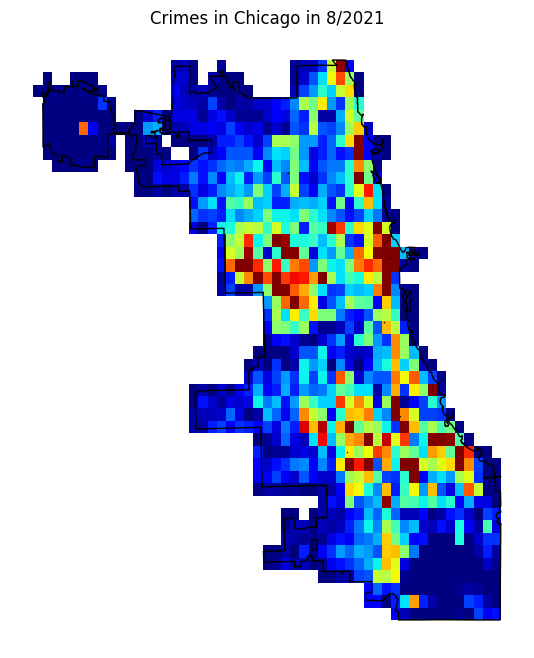

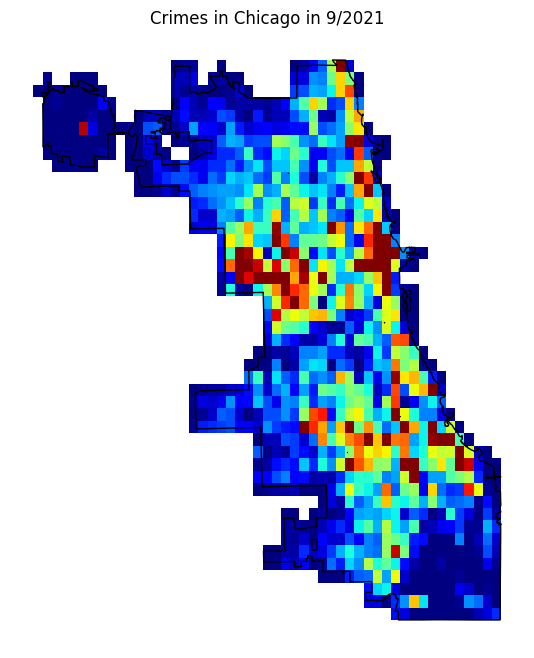

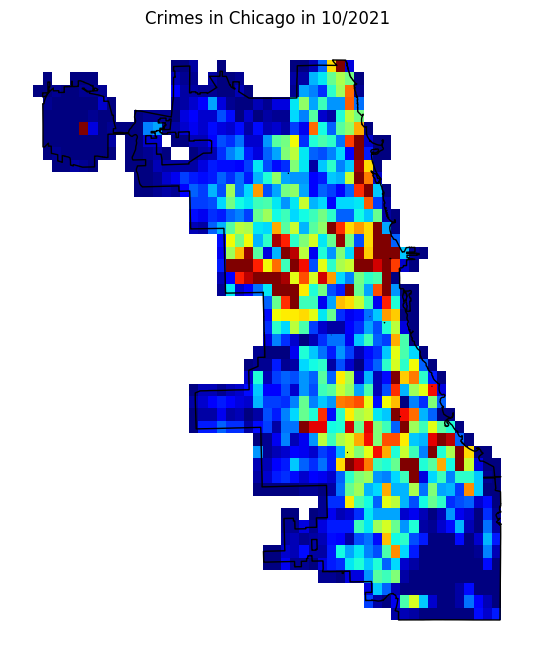

In [41]:
for month in range(1,13):
    month_crime_df = year_crime_df.loc[(crime_df['Date'] >= f'{month:02d}/01/2021') & (crime_df['Date'] <= f'{month:02d}/31/2021')]
    plot_crime_data(month_crime_df, month)

In [39]:
import imageio
import os

images = []
for filename in [f'frame_{frame_i}.png' for frame_i in range(1,12)]: 
    images.append(imageio.imread('data/visualisation/' + filename))
imageio.mimsave('data/crime.gif', images, 'GIF', fps=2)